In [59]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
import pickle

import warnings
warnings.filterwarnings('ignore') # 경고 메세지 OFF

#### 각 크립토 시장 데이터 불러오기

In [60]:
BTC = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/비트코인 과거 데이터.csv")
ETH = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/이더리움 과거 데이터.csv")
BNB = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/BNB 과거 데이터.csv")
DOT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Polkadot 과거 데이터.csv")
SOL = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Solana 과거 데이터.csv")
FTT = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/FTX Token 과거 데이터.csv")
XRP = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/XRP 과거 데이터.csv")
UNI = pd.read_csv("/home/user/exercise_j/GPT Project/LSTM/Uniswap 과거 데이터.csv")

#### Q(투자자 기대 수익률) 불러오기

In [61]:
# Q 벡터를 pickle 파일에서 불러오기
with open('q_vector.pkl', 'rb') as f:
    Q = pickle.load(f)

dates = pd.date_range(start='2023-06-01', end='2023-12-31')
# Q 딕셔너리를 DataFrame으로 변환
Q_df = pd.DataFrame.from_dict(Q, orient='index', columns=dates)

# [[]] 구조를 제거하고 단일 값으로 변환
for col in Q_df.columns:
    Q_df[col] = Q_df[col].apply(lambda x: x[0][0] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], list) and len(x[0]) > 0 else x)

Q_df

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
BTC,0.069148,0.068357,0.056369,0.061614,0.074483,0.055164,0.077118,0.075367,0.095014,0.074685,...,-0.028846,-0.003103,-0.003578,-0.024783,-0.019111,-0.031608,0.009679,0.011296,-0.004304,-0.005677
ETH,0.068098,0.069773,0.052194,0.052120,0.051403,0.054082,0.065499,0.060563,0.069176,0.070229,...,-0.016070,0.036365,0.051200,0.010292,0.011652,-0.000255,0.035434,0.037125,0.026768,0.025885
BNB,0.082978,0.089520,0.071055,0.057190,0.063989,0.040308,0.066435,0.053898,0.061929,0.051706,...,0.013692,0.052309,0.051247,0.037046,0.062104,0.050248,0.092209,0.090713,0.088571,0.087455
DOT,0.065217,0.071790,0.060592,0.071731,0.068410,0.062395,0.076304,0.043869,0.057723,0.060043,...,0.001284,0.026818,0.024303,0.024634,0.037021,0.021484,0.031875,0.031522,0.028263,0.028038
SOL,0.071685,0.071451,0.063690,0.050373,0.057988,0.051516,0.061380,0.046964,0.062355,0.041585,...,-0.041922,0.008202,0.021343,0.012168,0.012367,0.004647,0.022366,0.027355,0.024306,0.024683
FTT,0.047389,0.058944,0.052524,0.055019,0.063738,0.062033,0.067302,0.067668,0.067144,0.065170,...,0.019756,0.018765,0.008973,0.024405,0.025517,0.023323,0.025168,0.031907,0.029942,0.027716
XRP,0.038642,0.040194,0.034856,0.032696,0.034718,0.030672,0.034671,0.033030,0.038070,0.031003,...,-0.001239,0.014430,0.013628,0.006529,0.009583,-0.001010,0.017071,0.015982,0.012779,0.008333
UNI,0.065870,0.066699,0.057704,0.042088,0.047565,0.026905,0.040038,0.015388,0.020297,0.030404,...,-0.010639,0.022108,0.021672,0.016495,0.023125,0.018247,0.035041,0.031667,0.025671,0.030575


In [62]:
# 날짜 범위 정의
start_date = pd.to_datetime('2023-06-01')
end_date = pd.to_datetime('2023-12-31')

# 데이터프레임과 티커 이름을 매핑
ticker_dfs = {'BTC':BTC, 'ETH': ETH, 'BNB': BNB, 'DOT': DOT, 'SOL': SOL, 'FTT': FTT, 'XRP':XRP,'UNI':UNI}

# 각 데이터프레임을 처리하고 결과를 저장
filtered_dfs = {}
for ticker, df in ticker_dfs.items():
    # 필요없는 열 삭제
    
    del df['고가']
    del df['시가']
    del df['저가']
    del df['거래량']
    del df['종가']
    # 날짜 열을 datetime 객체로 변환
    df['created_at'] = pd.to_datetime(df['날짜'])
    del df['날짜']
    df['변동 %'] = df['변동 %'].str.replace('%', '').astype(float)
    # 주어진 날짜 범위에 맞게 필터링
    filtered_df2 = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)]
    filtered_df2.reset_index(drop=True, inplace=True)

    # 필터링된 데이터프레임을 딕셔너리에 저장
    filtered_dfs[ticker] = filtered_df2

In [63]:
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
returns = pd.DataFrame(index=all_dates)

# 각 크립토의 '변동 %' 데이터를 새로운 데이터프레임에 추가
for ticker, df in filtered_dfs.items():
    df.set_index('created_at', inplace=True)  # 'created_at'을 인덱스로 설정
    df = df.reindex(all_dates)  # 모든 날짜에 대해 데이터프레임을 재정렬
    returns[ticker] = df['변동 %']

#### RMSE & MAE 계산

In [64]:
transposed_returns = returns.transpose()
transposed_returns

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-12-22,2023-12-23,2023-12-24,2023-12-25,2023-12-26,2023-12-27,2023-12-28,2023-12-29,2023-12-30,2023-12-31
BTC,-1.46,1.59,-0.63,0.19,-5.07,5.76,-3.26,0.60,-0.08,-2.40,...,0.23,-0.59,-1.67,1.39,-2.44,2.20,-1.99,-1.19,0.15,0.32
ETH,-0.63,2.43,-0.79,-0.11,-4.17,4.03,-2.76,0.74,-0.29,-4.83,...,3.78,-0.67,-1.95,0.35,-1.79,6.63,-1.44,-1.93,-0.33,-0.43
BNB,-0.62,0.82,-0.23,-0.49,-9.18,1.45,-7.79,1.04,-0.54,-8.37,...,-0.22,-0.04,-2.36,0.91,11.62,8.79,-0.37,-2.85,0.96,-1.45
DOT,-2.05,1.36,1.16,-0.44,-4.68,2.68,-3.48,0.01,-0.85,-9.27,...,-5.64,4.87,3.30,6.66,-4.12,-1.38,-3.01,-1.62,0.64,-1.68
SOL,-1.56,3.71,-0.32,3.02,-8.38,1.95,-8.65,1.42,-7.91,-10.20,...,4.31,10.18,4.19,7.37,-6.76,-5.17,-4.62,4.24,-4.11,-0.21
FTT,-1.67,3.95,-3.80,3.42,-10.06,2.67,1.78,20.76,-13.73,-12.50,...,-1.58,2.37,0.54,-1.56,-5.50,-2.01,-7.95,-4.11,13.83,-9.74
XRP,-1.99,3.59,-1.12,3.28,-5.01,4.11,-2.19,1.06,2.72,-5.79,...,0.04,-0.77,-1.21,5.56,-3.73,2.00,0.02,-1.82,-0.36,-0.86
UNI,-0.85,1.72,0.36,-1.40,-5.76,0.97,-4.57,1.67,-1.00,-11.30,...,3.38,-0.83,7.95,1.84,5.46,-1.49,7.91,-3.13,-2.73,-1.87


In [65]:
# 티커별로 오차 계산
tickers = ['BTC', 'ETH', 'BNB', 'DOT', 'SOL', 'FTT', 'XRP', 'UNI']
for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))
    print(f"{ticker} RMSE: {rmse}")

    # MAE 계산
    mae = mean_absolute_error(actual_returns, expected_returns)
    print(f"{ticker} MAE: {mae}")

BTC RMSE: 2.0739587386112897
BTC MAE: 1.3530008567091516
ETH RMSE: 2.24527877661256
ETH MAE: 1.5068452209271284
BNB RMSE: 2.402043589816338
BNB MAE: 1.5589569669705163
DOT RMSE: 3.313819856745266
DOT MAE: 2.3034743898871537
SOL RMSE: 5.076622089219301
SOL MAE: 3.6379432611753586
FTT RMSE: 10.492721506824827
FTT MAE: 5.279955226393035
XRP RMSE: 5.691248622139011
XRP MAE: 2.23075082675247
UNI RMSE: 3.8569150137045405
UNI MAE: 2.5491376048306886


#### R2 & MAPE 값 추가

In [66]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 결과를 저장하기 위한 딕셔너리
results = {}

for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]
    actual_returns = actual_returns / 100.0
    # 오차 지표 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))
    mae = mean_absolute_error(actual_returns, expected_returns)
    mape = calculate_mape(actual_returns, expected_returns)
    r_squared = r2_score(actual_returns, expected_returns)

    # 결과 저장
    results[ticker] = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r_squared}

# 결과 출력
for ticker, metrics in results.items():
    print(f"{ticker}:")
    print(f"  RMSE: {metrics['RMSE']:.2f}")
    print(f"  MAE: {metrics['MAE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  R2: {metrics['R2']:.2f}")
    print("------")


BTC:
  RMSE: 0.04
  MAE: 0.03
  MAPE: 790.43%
  R2: -2.36
------
ETH:
  RMSE: 0.04
  MAE: 0.03
  MAPE: 683.33%
  R2: -1.86
------
BNB:
  RMSE: 0.04
  MAE: 0.04
  MAPE: inf%
  R2: -2.48
------
DOT:
  RMSE: 0.04
  MAE: 0.03
  MAPE: 635.34%
  R2: -0.54
------
SOL:
  RMSE: 0.05
  MAE: 0.04
  MAPE: 409.76%
  R2: -0.18
------
FTT:
  RMSE: 0.11
  MAE: 0.06
  MAPE: inf%
  R2: -0.05
------
XRP:
  RMSE: 0.06
  MAE: 0.03
  MAPE: inf%
  R2: -0.18
------
UNI:
  RMSE: 0.05
  MAE: 0.03
  MAPE: 333.56%
  R2: -0.37
------


In [51]:
# 결과를 저장할 딕셔너리
results = {}
transformed_market_data = pd.DataFrame()

for ticker in tickers:
    expected_returns = Q_df.loc[ticker]
    actual_returns = transposed_returns.loc[ticker]
    actual_returns = actual_returns / 100.0

    transformed_market_data[ticker] = transposed_returns.loc[ticker] / 100.0

    # RMSE 계산
    rmse = np.sqrt(mean_squared_error(actual_returns, expected_returns))

    # MAE 계산
    mae = mean_absolute_error(actual_returns, expected_returns)

    # R2 계산
    r_squared = r2_score(actual_returns, expected_returns)

    # MAPE 계산
    mape = calculate_mape(actual_returns, expected_returns)

    # 결과 저장
    results[ticker] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r_squared,
        'MAPE': mape
        }

#### 그래프 비교

In [53]:
transformed_market_data = transformed_market_data.transpose()

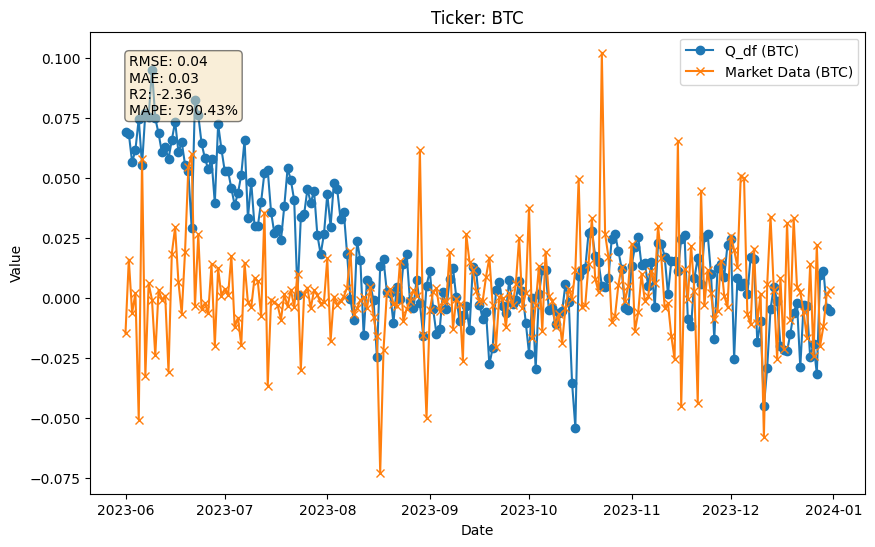

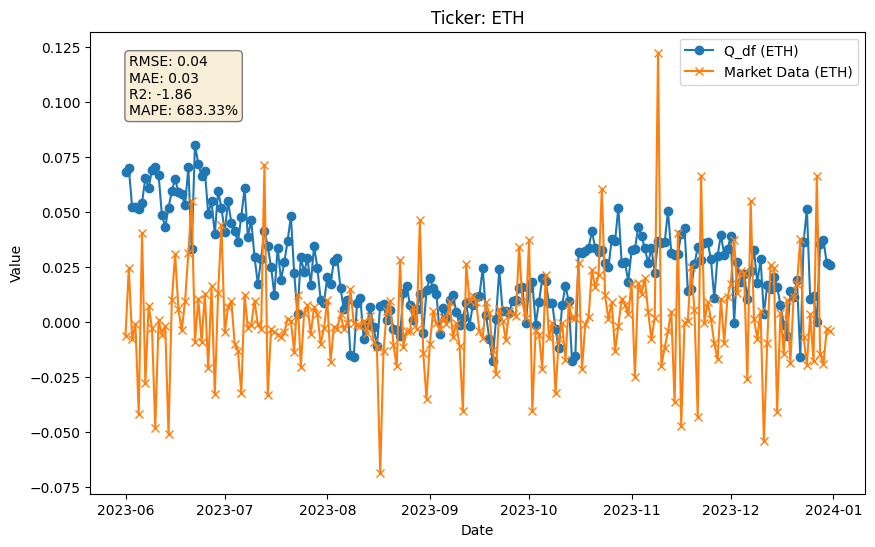

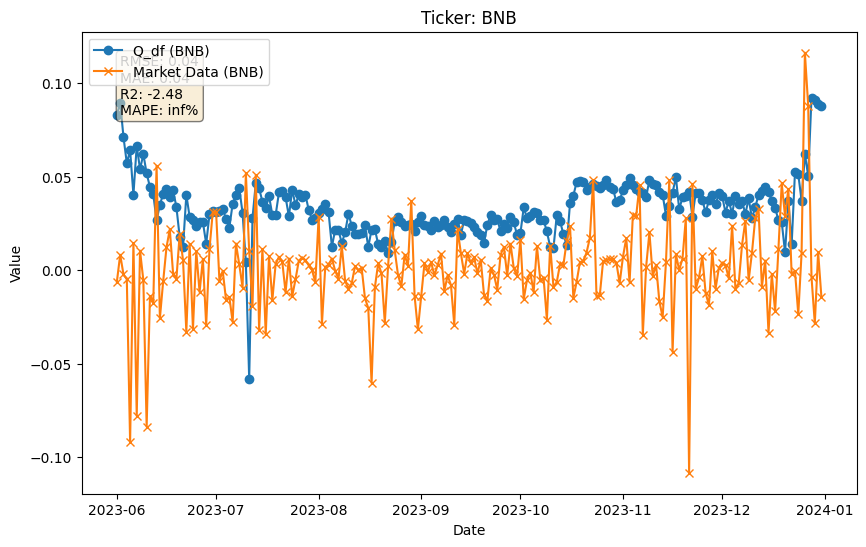

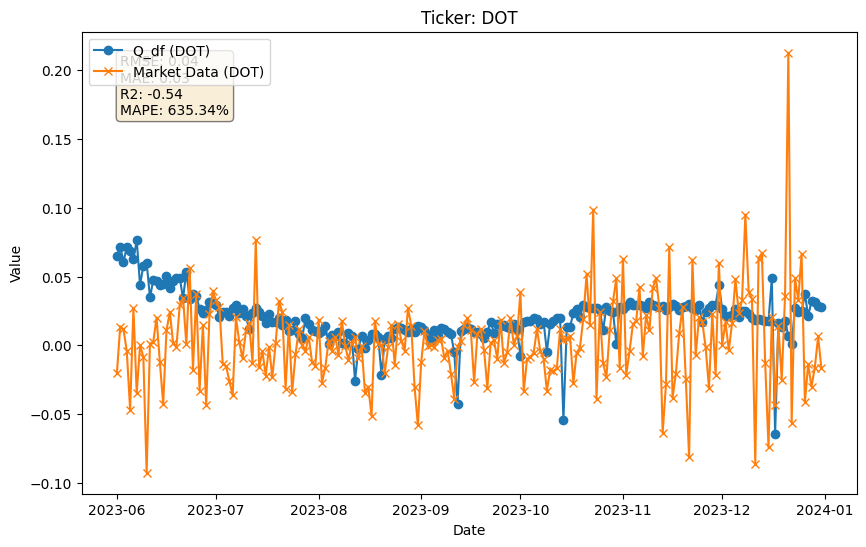

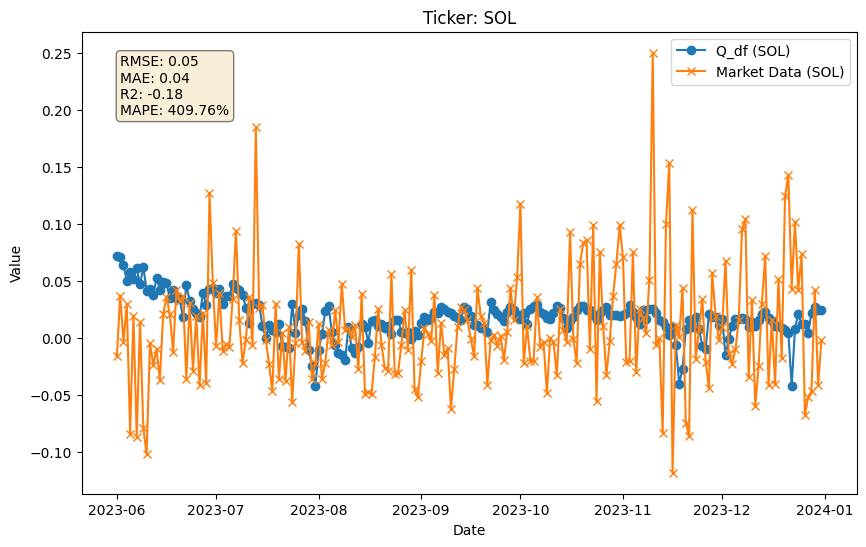

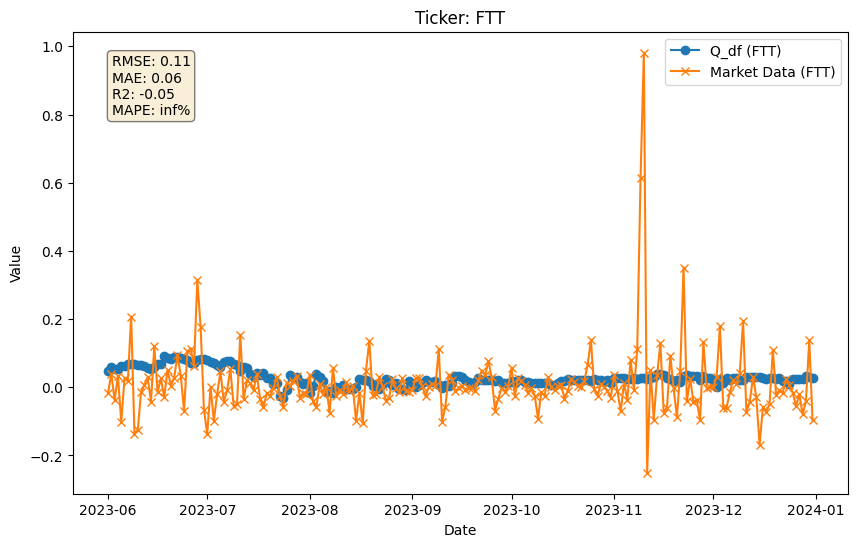

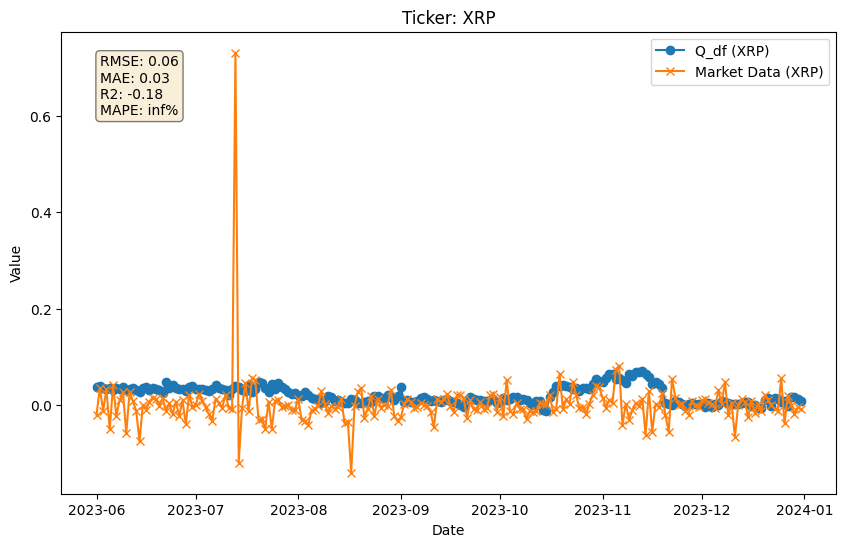

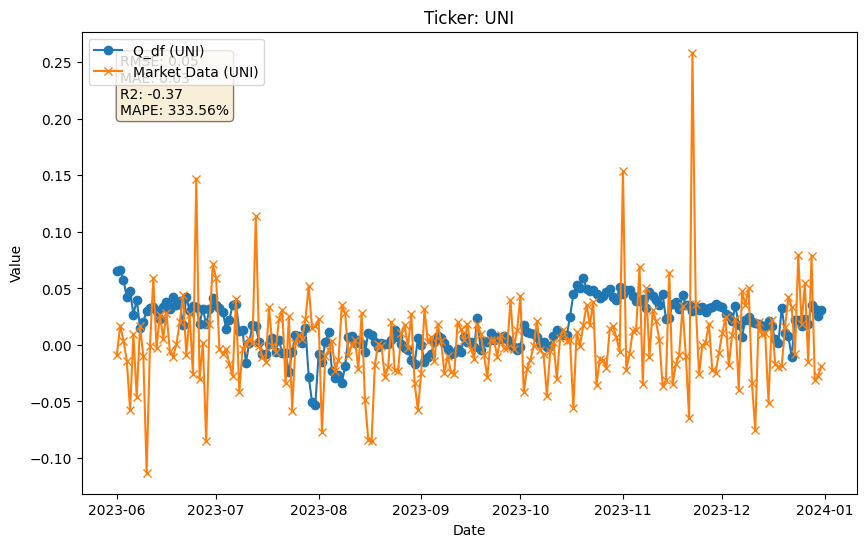

In [56]:
for ticker in tickers:
    fig, ax = plt.subplots(figsize=(10, 6))

    # Q_df와 시장 데이터 플롯
    ax.plot(Q_df.loc[ticker].index, Q_df.loc[ticker], label=f'Q_df ({ticker})', marker='o')
    ax.plot(transformed_market_data.loc[ticker].index, transformed_market_data.loc[ticker], label=f'Market Data ({ticker})', marker='x')

    # 오차 지표 추가
    metrics = results[ticker]
    textstr = '\n'.join((
        f'RMSE: {metrics["RMSE"]:.2f}',
        f'MAE: {metrics["MAE"]:.2f}',
        f'R2: {metrics["R2"]:.2f}',
        f'MAPE: {metrics["MAPE"]:.2f}%'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    # 그래프 설정
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(f'Ticker: {ticker}')
    ax.legend()
    plt.show()